Split 80/10/10 - Train/validation/Test

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import shutil

import pandas as pd
from tqdm import tqdm


In [3]:
base_dir = "/content/drive/MyDrive/data venture/ThermoDataBase"
dm_group_dir = os.path.join(base_dir, "DM Group")
cg_group_dir = os.path.join(base_dir, "Control Group")

output_dir = "/content/thermo_dataset"
os.makedirs(output_dir, exist_ok=True)


In [4]:
def extract_images(src_folder, label, output_dir):
    data = []
    for group in tqdm(os.listdir(src_folder), desc=f"Processing {label}"):
        group_path = os.path.join(src_folder, group)
        if os.path.isdir(group_path):
            for img in os.listdir(group_path):
                if img.endswith((".png", ".jpg", ".jpeg")):  # Check for valid image extensions
                    src_path = os.path.join(group_path, img)
                    dest_path = os.path.join(output_dir, img)
                    shutil.copy(src_path, dest_path)  # Copy image to output directory
                    data.append((dest_path, label))  # Store file path and label
    return data

dm_data = extract_images(dm_group_dir, "DM", output_dir)
cg_data = extract_images(cg_group_dir, "CG", output_dir)

df = pd.DataFrame(dm_data + cg_data, columns=["image_path", "label"])

df.to_csv("/content/thermo_dataset_labels.csv", index=False)
print("Dataset extraction complete. CSV saved!")


Processing CG: 100%|██████████| 45/45 [00:30<00:00,  1.46it/s]

Dataset extraction complete. CSV saved!


In [5]:
df

,image_path,label
0,/content/thermo_dataset/DM058_F_R.png,DM
1,/content/thermo_dataset/DM058_F_L.png,DM
2,/content/thermo_dataset/DM096_M_L.png,DM
3,/content/thermo_dataset/DM096_M_R.png,DM
4,/content/thermo_dataset/DM052_F_L.png,DM
...,...,...
329,/content/thermo_dataset/CG015_M_R.png,CG
330,/content/thermo_dataset/CG034_M_L.png,CG
331,/content/thermo_dataset/CG034_M_R.png,CG
332,/content/thermo_dataset/CG017_F_L.png,CG


from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

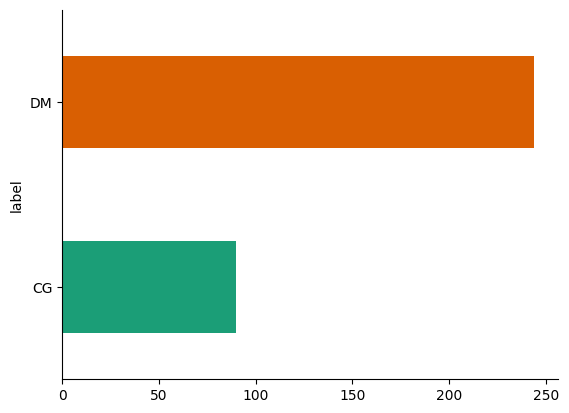

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
!pip install timm  # For Vision Transformer & EfficientNet


In [8]:
import os
import shutil
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd
from PIL import Image
import timm


In [36]:

df['label'] = df['label'].map({'DM': 1, 'CG': 0})

In [37]:
df = df.sample(frac=1).reset_index(drop=True)


In [38]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(degrees=15),   # Random rotation between -15 to 15 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop & resize with variation
    transforms.ToTensor(),  # Convert to tensor for model input
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize to ImageNet stats (optional)
])


In [21]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

resnet_model = timm.create_model('resnet50', pretrained=True, num_classes=2)
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
efficient_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)
vit_model.to(device)
efficient_model.to(device)


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [40]:
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset
import os
from sklearn.preprocessing import LabelEncoder

class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.df['label'] = self.label_encoder.fit_transform(self.df['label'])  # Encode labels as 0 (CG) and 1 (DM)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]  # Label (CG or DM)

        # Load image
        image = Image.open(image_path).convert("RGB")  # Keep image in RGB mode

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])




In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
train_dataset = CustomImageDataset(df=train_df, transform=transform)
val_dataset = CustomImageDataset(df=val_df, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    all_preds = []
    all_labels = []

    # Start training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Train on batches
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update weights

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Store predictions and labels for confusion matrix
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Store metrics for plotting
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(100 * correct / total)
        val_accuracies.append(100 * val_correct / val_total)

        # Print stats
        print(f"Epoch {epoch + 1}/{epochs}:")
        print(f"  Train Loss: {train_losses[-1]}  Train Accuracy: {train_accuracies[-1]}%")
        print(f"  Validation Loss: {val_losses[-1]}  Validation Accuracy: {val_accuracies[-1]}%")

        # Step the scheduler
        scheduler.step()

    # Plotting the training and validation metrics
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CG', 'DM'], yticklabels=['CG', 'DM'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return model


Training ResNet50 model...


Epoch 1/50: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


Epoch 1/50:
  Train Loss: 0.12129160637656848  Train Accuracy: 95.88014981273409%
  Validation Loss: 1.404992773818473  Validation Accuracy: 88.05970149253731%


Epoch 2/50: 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


Epoch 2/50:
  Train Loss: 0.10526073165237904  Train Accuracy: 96.25468164794007%
  Validation Loss: 0.7482042411963145  Validation Accuracy: 85.07462686567165%


Epoch 3/50: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


Epoch 3/50:
  Train Loss: 0.1585536330110497  Train Accuracy: 92.88389513108615%
  Validation Loss: 0.3320867841442426  Validation Accuracy: 80.59701492537313%


Epoch 4/50: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


Epoch 4/50:
  Train Loss: 0.16156444864140618  Train Accuracy: 93.63295880149813%
  Validation Loss: 0.47130199273427326  Validation Accuracy: 82.08955223880596%


Epoch 5/50: 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


Epoch 5/50:
  Train Loss: 0.20568020145098367  Train Accuracy: 92.13483146067416%
  Validation Loss: 1.5238409526646137  Validation Accuracy: 85.07462686567165%


Epoch 6/50: 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]


Epoch 6/50:
  Train Loss: 0.11580380631817712  Train Accuracy: 94.38202247191012%
  Validation Loss: 0.529655026892821  Validation Accuracy: 88.05970149253731%


Epoch 7/50: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Epoch 7/50:
  Train Loss: 0.10063489547206296  Train Accuracy: 97.37827715355806%
  Validation Loss: 0.48260052502155304  Validation Accuracy: 89.55223880597015%


Epoch 8/50: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Epoch 8/50:
  Train Loss: 0.04087441104153792  Train Accuracy: 98.50187265917603%
  Validation Loss: 0.6396178975701332  Validation Accuracy: 92.53731343283582%


Epoch 9/50: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


Epoch 9/50:
  Train Loss: 0.037318400779945984  Train Accuracy: 98.87640449438203%
  Validation Loss: 0.9094685862461726  Validation Accuracy: 89.55223880597015%


Epoch 10/50: 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


Epoch 10/50:
  Train Loss: 0.07228495651442143  Train Accuracy: 97.37827715355806%
  Validation Loss: 0.858946884671847  Validation Accuracy: 89.55223880597015%


Epoch 11/50: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


Epoch 11/50:
  Train Loss: 0.035117655992507935  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.39595358818769455  Validation Accuracy: 89.55223880597015%


Epoch 12/50: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Epoch 12/50:
  Train Loss: 0.06087296704451243  Train Accuracy: 98.87640449438203%
  Validation Loss: 0.8009965245922407  Validation Accuracy: 89.55223880597015%


Epoch 13/50: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Epoch 13/50:
  Train Loss: 0.02908965324362119  Train Accuracy: 99.25093632958801%
  Validation Loss: 0.4793884741763274  Validation Accuracy: 91.04477611940298%


Epoch 14/50: 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


Epoch 14/50:
  Train Loss: 0.03655853319085307  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.5338853566596905  Validation Accuracy: 94.02985074626865%


Epoch 15/50: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Epoch 15/50:
  Train Loss: 0.031811046672777996  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.4943398144096136  Validation Accuracy: 94.02985074626865%


Epoch 16/50: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


Epoch 16/50:
  Train Loss: 0.020622680170668498  Train Accuracy: 100.0%
  Validation Loss: 0.7242258004844189  Validation Accuracy: 92.53731343283582%


Epoch 17/50: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Epoch 17/50:
  Train Loss: 0.015623415005393326  Train Accuracy: 100.0%
  Validation Loss: 0.48956842130670947  Validation Accuracy: 91.04477611940298%


Epoch 18/50: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


Epoch 18/50:
  Train Loss: 0.02192921879597836  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.7536360109224916  Validation Accuracy: 94.02985074626865%


Epoch 19/50: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


Epoch 19/50:
  Train Loss: 0.02658289060410526  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.7802777687708536  Validation Accuracy: 89.55223880597015%


Epoch 20/50: 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


Epoch 20/50:
  Train Loss: 0.02623890547288789  Train Accuracy: 100.0%
  Validation Loss: 0.44734226043025654  Validation Accuracy: 89.55223880597015%


Epoch 21/50: 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


Epoch 21/50:
  Train Loss: 0.03218692313465807  Train Accuracy: 98.87640449438203%
  Validation Loss: 0.49597913833955926  Validation Accuracy: 91.04477611940298%


Epoch 22/50: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


Epoch 22/50:
  Train Loss: 0.027347151707443926  Train Accuracy: 99.25093632958801%
  Validation Loss: 0.6111405417323112  Validation Accuracy: 91.04477611940298%


Epoch 23/50: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


Epoch 23/50:
  Train Loss: 0.03301663137972355  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.5251896604895592  Validation Accuracy: 92.53731343283582%


Epoch 24/50: 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


Epoch 24/50:
  Train Loss: 0.027988996925867267  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.6961283547182878  Validation Accuracy: 89.55223880597015%


Epoch 25/50: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Epoch 25/50:
  Train Loss: 0.045398077824049525  Train Accuracy: 98.50187265917603%
  Validation Loss: 0.6226324290037155  Validation Accuracy: 86.56716417910448%


Epoch 26/50: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


Epoch 26/50:
  Train Loss: 0.04021677975025442  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.23425772413611412  Validation Accuracy: 91.04477611940298%


Epoch 27/50: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


Epoch 27/50:
  Train Loss: 0.027795992688172393  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.7273861393332481  Validation Accuracy: 89.55223880597015%


Epoch 28/50: 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


Epoch 28/50:
  Train Loss: 0.04907400378336509  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.8514004362126192  Validation Accuracy: 92.53731343283582%


Epoch 29/50: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


Epoch 29/50:
  Train Loss: 0.01493796825201975  Train Accuracy: 100.0%
  Validation Loss: 0.5945565005143484  Validation Accuracy: 91.04477611940298%


Epoch 30/50: 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


Epoch 30/50:
  Train Loss: 0.01678600079483456  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.29411912088592845  Validation Accuracy: 94.02985074626865%


Epoch 31/50: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Epoch 31/50:
  Train Loss: 0.027913300630946953  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.7943199009944996  Validation Accuracy: 91.04477611940298%


Epoch 32/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch 32/50:
  Train Loss: 0.02551806728459067  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.6183637430270513  Validation Accuracy: 89.55223880597015%


Epoch 33/50: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Epoch 33/50:
  Train Loss: 0.03240885269931621  Train Accuracy: 98.87640449438203%
  Validation Loss: 0.6763494362433752  Validation Accuracy: 94.02985074626865%


Epoch 34/50: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Epoch 34/50:
  Train Loss: 0.02302429649151034  Train Accuracy: 99.25093632958801%
  Validation Loss: 0.5536918590466181  Validation Accuracy: 92.53731343283582%


Epoch 35/50: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


Epoch 35/50:
  Train Loss: 0.040039425094922386  Train Accuracy: 99.25093632958801%
  Validation Loss: 0.563486659899354  Validation Accuracy: 91.04477611940298%


Epoch 36/50: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


Epoch 36/50:
  Train Loss: 0.01733446682596372  Train Accuracy: 100.0%
  Validation Loss: 0.41477863614757854  Validation Accuracy: 89.55223880597015%


Epoch 37/50: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


Epoch 37/50:
  Train Loss: 0.034017228417926364  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.6075722997387251  Validation Accuracy: 91.04477611940298%


Epoch 38/50: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


Epoch 38/50:
  Train Loss: 0.03493714943114254  Train Accuracy: 98.87640449438203%
  Validation Loss: 0.5365357125798861  Validation Accuracy: 92.53731343283582%


Epoch 39/50: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]


Epoch 39/50:
  Train Loss: 0.024512540859480698  Train Accuracy: 100.0%
  Validation Loss: 0.31741700942317647  Validation Accuracy: 92.53731343283582%


Epoch 40/50: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


Epoch 40/50:
  Train Loss: 0.02327575379361709  Train Accuracy: 100.0%
  Validation Loss: 0.6613918927808603  Validation Accuracy: 92.53731343283582%


Epoch 41/50: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Epoch 41/50:
  Train Loss: 0.027558107653425798  Train Accuracy: 98.50187265917603%
  Validation Loss: 0.3938502719004949  Validation Accuracy: 92.53731343283582%


Epoch 42/50: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


Epoch 42/50:
  Train Loss: 0.02149622980505228  Train Accuracy: 100.0%
  Validation Loss: 0.5430019795894623  Validation Accuracy: 89.55223880597015%


Epoch 43/50: 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


Epoch 43/50:
  Train Loss: 0.02712539066043165  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.7766900671025118  Validation Accuracy: 86.56716417910448%


Epoch 44/50: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


Epoch 44/50:
  Train Loss: 0.029445538349035714  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.7065874487161636  Validation Accuracy: 89.55223880597015%


Epoch 45/50: 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


Epoch 45/50:
  Train Loss: 0.015462817210290167  Train Accuracy: 100.0%
  Validation Loss: 0.6613797210156918  Validation Accuracy: 92.53731343283582%


Epoch 46/50: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


Epoch 46/50:
  Train Loss: 0.01901720029612382  Train Accuracy: 100.0%
  Validation Loss: 0.2914474792778492  Validation Accuracy: 91.04477611940298%


Epoch 47/50: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Epoch 47/50:
  Train Loss: 0.014863714265326658  Train Accuracy: 100.0%
  Validation Loss: 0.3716743631909291  Validation Accuracy: 89.55223880597015%


Epoch 48/50: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


Epoch 48/50:
  Train Loss: 0.11747004329744312  Train Accuracy: 98.50187265917603%
  Validation Loss: 0.5247464360048374  Validation Accuracy: 89.55223880597015%


Epoch 49/50: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


Epoch 49/50:
  Train Loss: 0.022790548339900043  Train Accuracy: 99.25093632958801%
  Validation Loss: 0.2979952668150266  Validation Accuracy: 92.53731343283582%


Epoch 50/50: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch 50/50:
  Train Loss: 0.018742721683035295  Train Accuracy: 99.62546816479401%
  Validation Loss: 0.6977641517296433  Validation Accuracy: 92.53731343283582%


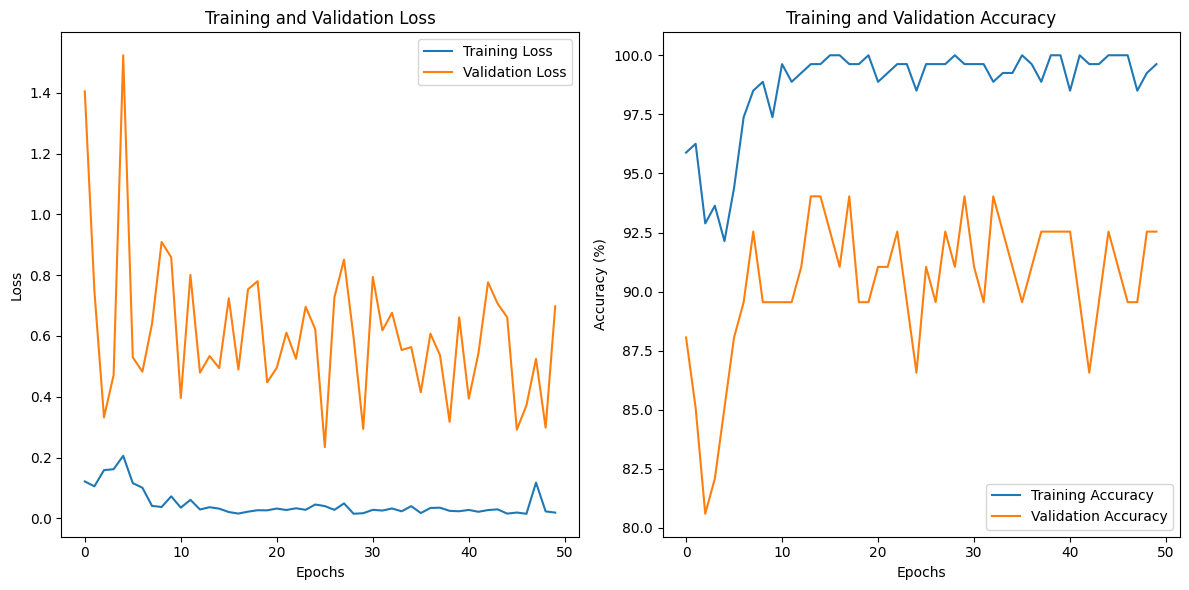

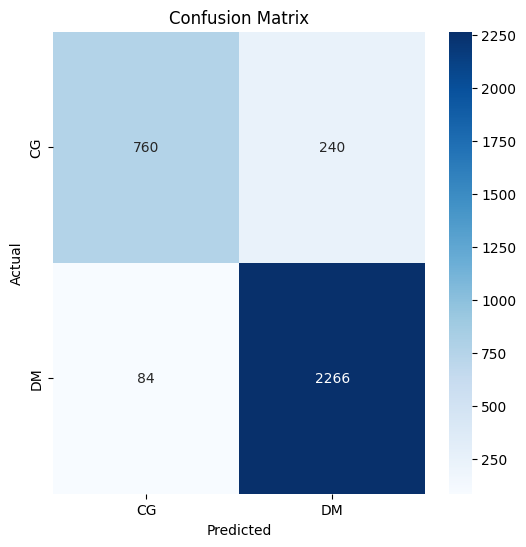

In [33]:
print("Training ResNet50 model...")
trained_resnet = train_model(resnet_model, train_loader, val_loader, epochs=50, lr=0.001)


In [34]:
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Accuracy on the test dataset: {accuracy * 100:.2f}%')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CG', 'DM'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return accuracy


Evaluating ResNet50 model...
Accuracy on the test dataset: 99.63%


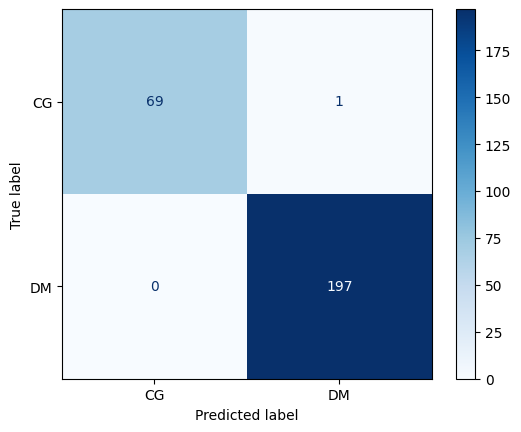

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating ResNet50 model...")
trained_resnet.eval()
test_accuracy = evaluate_model(trained_resnet, test_loader, device)


Training Vision Transformer (ViT) model...


Epoch 1/50: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Epoch 1/50:
  Train Loss: 5.021967927614848  Train Accuracy: 56.554307116104866%
  Validation Loss: 2.200377737482389  Validation Accuracy: 70.14925373134328%


Epoch 2/50: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 2/50:
  Train Loss: 0.9748730957508087  Train Accuracy: 64.04494382022472%
  Validation Loss: 0.7159000436464945  Validation Accuracy: 70.14925373134328%


Epoch 3/50: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Epoch 3/50:
  Train Loss: 0.5983667373657227  Train Accuracy: 73.78277153558052%
  Validation Loss: 0.6883598963419596  Validation Accuracy: 29.850746268656717%


Epoch 4/50: 100%|██████████| 9/9 [00:10<00:00,  1.18s/it]


Epoch 4/50:
  Train Loss: 0.6655112273163266  Train Accuracy: 64.7940074906367%
  Validation Loss: 0.7009037137031555  Validation Accuracy: 70.14925373134328%


Epoch 5/50: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


Epoch 5/50:
  Train Loss: 0.577366418308682  Train Accuracy: 73.78277153558052%
  Validation Loss: 0.9245368738969167  Validation Accuracy: 70.14925373134328%


Epoch 6/50: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 6/50:
  Train Loss: 0.6132453911834292  Train Accuracy: 73.78277153558052%
  Validation Loss: 1.2216177607576053  Validation Accuracy: 70.14925373134328%


Epoch 7/50: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


Epoch 7/50:
  Train Loss: 0.5915607412656149  Train Accuracy: 73.78277153558052%
  Validation Loss: 0.6892476379871368  Validation Accuracy: 70.14925373134328%


Epoch 8/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 8/50:
  Train Loss: 0.49141015940242344  Train Accuracy: 73.78277153558052%
  Validation Loss: 0.6326963802178701  Validation Accuracy: 70.14925373134328%


Epoch 9/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 9/50:
  Train Loss: 0.4541550576686859  Train Accuracy: 72.65917602996255%
  Validation Loss: 0.6343982021013895  Validation Accuracy: 76.11940298507463%


Epoch 10/50: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 10/50:
  Train Loss: 0.4316706723637051  Train Accuracy: 69.66292134831461%
  Validation Loss: 0.5108147958914439  Validation Accuracy: 85.07462686567165%


Epoch 11/50: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Epoch 11/50:
  Train Loss: 0.4266967740323808  Train Accuracy: 69.66292134831461%
  Validation Loss: 0.511241172750791  Validation Accuracy: 80.59701492537313%


Epoch 12/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 12/50:
  Train Loss: 0.42016743620236713  Train Accuracy: 71.91011235955057%
  Validation Loss: 0.549797515074412  Validation Accuracy: 70.14925373134328%


Epoch 13/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 13/50:
  Train Loss: 0.42640673286385006  Train Accuracy: 73.03370786516854%
  Validation Loss: 0.5555844654639562  Validation Accuracy: 70.14925373134328%


Epoch 14/50: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


Epoch 14/50:
  Train Loss: 0.4258616334862179  Train Accuracy: 75.28089887640449%
  Validation Loss: 0.5017111748456955  Validation Accuracy: 86.56716417910448%


Epoch 15/50: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 15/50:
  Train Loss: 0.4106150269508362  Train Accuracy: 70.0374531835206%
  Validation Loss: 0.5108217696348826  Validation Accuracy: 76.11940298507463%


Epoch 16/50: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Epoch 16/50:
  Train Loss: 0.40524004234208  Train Accuracy: 70.0374531835206%
  Validation Loss: 0.5329262713591257  Validation Accuracy: 70.14925373134328%


Epoch 17/50: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 17/50:
  Train Loss: 0.4053267074955834  Train Accuracy: 72.65917602996255%
  Validation Loss: 0.5327714731295904  Validation Accuracy: 70.14925373134328%


Epoch 18/50: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 18/50:
  Train Loss: 0.39838775826825035  Train Accuracy: 73.03370786516854%
  Validation Loss: 0.5435921351114908  Validation Accuracy: 70.14925373134328%


Epoch 19/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 19/50:
  Train Loss: 0.40876028272840714  Train Accuracy: 72.65917602996255%
  Validation Loss: 0.5247457176446915  Validation Accuracy: 70.14925373134328%


Epoch 20/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 20/50:
  Train Loss: 0.40310897098647225  Train Accuracy: 71.91011235955057%
  Validation Loss: 0.5234447121620178  Validation Accuracy: 73.13432835820896%


Epoch 21/50: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Epoch 21/50:
  Train Loss: 0.4015621278021071  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5280628005663554  Validation Accuracy: 71.64179104477611%


Epoch 22/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 22/50:
  Train Loss: 0.4257299171553718  Train Accuracy: 71.16104868913858%
  Validation Loss: 0.5296179205179214  Validation Accuracy: 73.13432835820896%


Epoch 23/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 23/50:
  Train Loss: 0.4124464624457889  Train Accuracy: 70.78651685393258%
  Validation Loss: 0.5116409460703532  Validation Accuracy: 73.13432835820896%


Epoch 24/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 24/50:
  Train Loss: 0.3978361090024312  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5131627221902212  Validation Accuracy: 74.6268656716418%


Epoch 25/50: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 25/50:
  Train Loss: 0.40903954373465645  Train Accuracy: 69.66292134831461%
  Validation Loss: 0.5179305771986643  Validation Accuracy: 74.6268656716418%


Epoch 26/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 26/50:
  Train Loss: 0.40703093343310887  Train Accuracy: 69.28838951310861%
  Validation Loss: 0.5312075217564901  Validation Accuracy: 74.6268656716418%


Epoch 27/50: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


Epoch 27/50:
  Train Loss: 0.4158286650975545  Train Accuracy: 69.28838951310861%
  Validation Loss: 0.5151529113451639  Validation Accuracy: 74.6268656716418%


Epoch 28/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 28/50:
  Train Loss: 0.3971443408065372  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5057190756003062  Validation Accuracy: 77.61194029850746%


Epoch 29/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 29/50:
  Train Loss: 0.4138727817270491  Train Accuracy: 70.78651685393258%
  Validation Loss: 0.5215362012386322  Validation Accuracy: 77.61194029850746%


Epoch 30/50: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 30/50:
  Train Loss: 0.40725961989826626  Train Accuracy: 70.78651685393258%
  Validation Loss: 0.5383397787809372  Validation Accuracy: 77.61194029850746%


Epoch 31/50: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Epoch 31/50:
  Train Loss: 0.41622455252541435  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5106769154469172  Validation Accuracy: 77.61194029850746%


Epoch 32/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 32/50:
  Train Loss: 0.4144786033365462  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.515712653597196  Validation Accuracy: 77.61194029850746%


Epoch 33/50: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 33/50:
  Train Loss: 0.40531660781966317  Train Accuracy: 71.16104868913858%
  Validation Loss: 0.5036181261142095  Validation Accuracy: 76.11940298507463%


Epoch 34/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 34/50:
  Train Loss: 0.4072369668218825  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5174310803413391  Validation Accuracy: 77.61194029850746%


Epoch 35/50: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Epoch 35/50:
  Train Loss: 0.4183812340100606  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5356326947609583  Validation Accuracy: 76.11940298507463%


Epoch 36/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 36/50:
  Train Loss: 0.39424315922790104  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5368165075778961  Validation Accuracy: 76.11940298507463%


Epoch 37/50: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 37/50:
  Train Loss: 0.40478330188327366  Train Accuracy: 70.0374531835206%
  Validation Loss: 0.5335131386915842  Validation Accuracy: 76.11940298507463%


Epoch 38/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 38/50:
  Train Loss: 0.41028884053230286  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.510871152083079  Validation Accuracy: 77.61194029850746%


Epoch 39/50: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Epoch 39/50:
  Train Loss: 0.4112182358900706  Train Accuracy: 70.78651685393258%
  Validation Loss: 0.5103644579648972  Validation Accuracy: 77.61194029850746%


Epoch 40/50: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]


Epoch 40/50:
  Train Loss: 0.39934638142585754  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.509601096312205  Validation Accuracy: 77.61194029850746%


Epoch 41/50: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


Epoch 41/50:
  Train Loss: 0.404089930984709  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5154925088087717  Validation Accuracy: 76.11940298507463%


Epoch 42/50: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


Epoch 42/50:
  Train Loss: 0.4122653239303165  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5177422265211741  Validation Accuracy: 77.61194029850746%


Epoch 43/50: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


Epoch 43/50:
  Train Loss: 0.40156782004568314  Train Accuracy: 70.78651685393258%
  Validation Loss: 0.53787761926651  Validation Accuracy: 77.61194029850746%


Epoch 44/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 44/50:
  Train Loss: 0.4062685900264316  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5197172065575918  Validation Accuracy: 77.61194029850746%


Epoch 45/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 45/50:
  Train Loss: 0.4102295935153961  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5244900484879812  Validation Accuracy: 77.61194029850746%


Epoch 46/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 46/50:
  Train Loss: 0.3968268715673023  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5105424125989279  Validation Accuracy: 77.61194029850746%


Epoch 47/50: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


Epoch 47/50:
  Train Loss: 0.40238962570826214  Train Accuracy: 70.78651685393258%
  Validation Loss: 0.5373510221640269  Validation Accuracy: 77.61194029850746%


Epoch 48/50: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


Epoch 48/50:
  Train Loss: 0.4066311849488152  Train Accuracy: 70.0374531835206%
  Validation Loss: 0.5358769645293554  Validation Accuracy: 77.61194029850746%


Epoch 49/50: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


Epoch 49/50:
  Train Loss: 0.40299664934476215  Train Accuracy: 70.78651685393258%
  Validation Loss: 0.5174792210261027  Validation Accuracy: 77.61194029850746%


Epoch 50/50: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


Epoch 50/50:
  Train Loss: 0.42269858717918396  Train Accuracy: 70.4119850187266%
  Validation Loss: 0.5163441101710001  Validation Accuracy: 77.61194029850746%


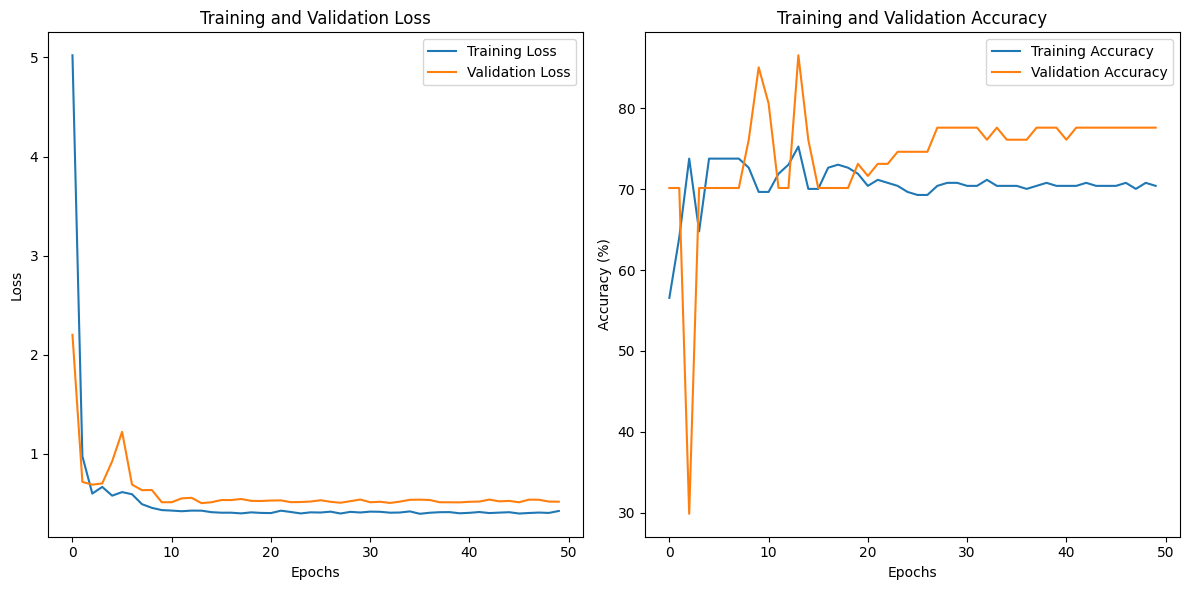

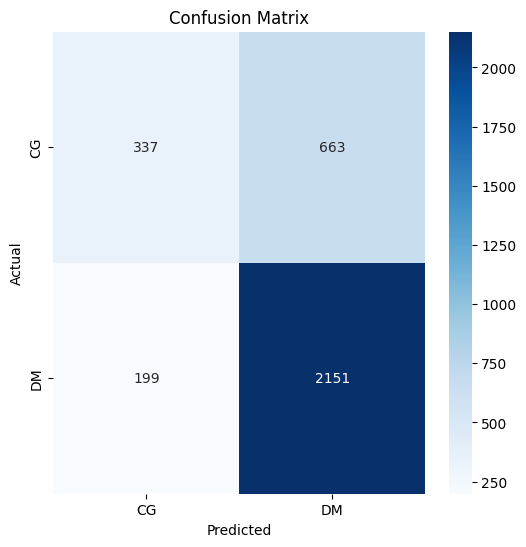

In [45]:
print("Training Vision Transformer (ViT) model...")
trained_vit = train_model(vit_model, train_loader, val_loader, epochs=50, lr=0.001)
